# Submissions : 


In [1]:
predictions = np.exp(my_model.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

NameError: name 'np' is not defined

# Import and configurations

In [2]:
import sys
import os

# Añadir la ruta al directorio del archivo .py
sys.path.append('/kaggle/input/libraries/utils_reg_eval')
import Utils # pronto cambiaremos el nombre a eval_reg_utils

In [3]:

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')


/tmp/ipykernel_34/676408276.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


These are only a couple ways you could use the principal components. You could also try clustering using one or more components. One thing to note is that PCA doesn't change the distance between points -- it's just like a rotation. So clustering with the full set of components is the same as clustering with the original features. Instead, pick some subset of components, maybe those with the most variance or the highest MI scores.

For further analysis, you might want to look at a correlation matrix for the dataset:


---

Aquí tienes la traducción del texto:

---

Estas son solo algunas formas en las que podrías usar los componentes principales. También podrías intentar realizar clustering utilizando uno o más componentes. Una cosa a tener en cuenta es que PCA no cambia la distancia entre puntos: es como una rotación. Así que hacer clustering con el conjunto completo de componentes es lo mismo que hacer clustering con las características originales. En su lugar, elige un subconjunto de componentes, tal vez aquellos con la mayor varianza o los puntajes de MI más altos.

Para un análisis más profundo, podrías querer ver una matriz de correlación para el conjunto de datos:

---

In [4]:
import pandas as pd

house_price_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col ='Id')
house_price_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv", index_col = 'Id')

print(house_price_train.SalePrice.dtype) # variable objetivo # El objetivo es predecir el "valor de venta" de una casa en funcion de sus caracteristicas

X = house_price_train
y = house_price_train.pop("SalePrice")


int64


In [5]:
X.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal


# Dividimos los datos

In [6]:
from sklearn.model_selection import train_test_split

def obtener_datos_reg(X,y, train_size=0.8, random_state=1):

    # Primera división: conjunto de prueba
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

    # Segunda división: conjunto de validación
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=train_size, random_state=random_state)

    total = X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]

    def porcent(num):
        result = num/total * 100 
        return f"{int(result)}%"

    print("el total de filas es : ", total)
    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}  -> {porcent(X_train.shape[0])}")
    print(f"Tamaño del conjunto de validación: {X_valid.shape[0]} -> {porcent(X_valid.shape[0])}")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} -> {porcent(X_test.shape[0])}")

    return X_train, X_valid, y_train, y_valid, X_test, y_test

# prueba de uso
X_train, X_valid, y_train, y_valid, X_test, y_test = obtener_datos_reg(X,y)

y_train.head()

el total de filas es :  1460
Tamaño del conjunto de entrenamiento: 934  -> 63%
Tamaño del conjunto de validación: 234 -> 16%
Tamaño del conjunto de prueba: 292 -> 20%


Id
616     137500
1008     88000
507     215000
1355    235000
918     135000
Name: SalePrice, dtype: int64

# Preprocesamos - scikit learn utils: 



#### podemos ir alternando entre usar el de pandas para poder manipular internamente con funciones de scikit learn y dejarlo con pandas, o en default para la pipeline de scikit : 

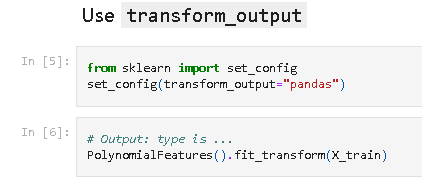

In [7]:
from sklearn import set_config
set_config(transform_output="default")

In [8]:
# Seleccionar las columnas numéricas
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'O']

# Definicion de Pipeline / Modelo : XGboost / Configurar la búsqueda de hiperparámetros con Optuna:

In [9]:
import optuna
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant', fill_value=0)

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 400),
        'max_depth': trial.suggest_int('max_depth', 1, 11),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 7),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1e-2),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1e-2),
    }

    model = XGBRegressor(**param)

    # Create the pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)
                                 ])
    
    # Perform cross-validation
    scores = -1 * cross_val_score(my_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
#     scores = cross_val_score(my_pipeline, X_train, y_train, cv=5, scoring='r2')
    
    return scores.mean()

# Create a study object and specify the direction as 'minimize'
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=140)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)


[I 2024-08-03 19:51:24,860] A new study created in memory with name: no-name-1f44bd41-461c-468a-a0f3-dd1b4bec3ccf
[I 2024-08-03 19:51:29,645] Trial 0 finished with value: 19122.591412718863 and parameters: {'n_estimators': 316, 'max_depth': 3, 'learning_rate': 0.2525621402786521, 'subsample': 0.7989472661329796, 'colsample_bytree': 0.8934298979433184, 'gamma': 4.518923357994013, 'reg_alpha': 0.00018992601991438612, 'reg_lambda': 1.964085481364824e-07}. Best is trial 0 with value: 19122.591412718863.
[I 2024-08-03 19:51:31,943] Trial 1 finished with value: 20733.76011959311 and parameters: {'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.016719824089890423, 'subsample': 0.6164298219893891, 'colsample_bytree': 0.8178559891306438, 'gamma': 2.2727911372984737, 'reg_alpha': 1.527086784092323e-06, 'reg_lambda': 0.00015267378125445618}. Best is trial 0 with value: 19122.591412718863.
[I 2024-08-03 19:51:42,545] Trial 2 finished with value: 17445.469977017565 and parameters: {'n_estima

Best hyperparameters:  {'n_estimators': 363, 'max_depth': 6, 'learning_rate': 0.024206140084899064, 'subsample': 0.5661364685340313, 'colsample_bytree': 0.41059382968111585, 'gamma': 1.987295633161507, 'reg_alpha': 0.0001372372496986934, 'reg_lambda': 1.988920280687874e-05}


# Entrenar el modelo con los mejores hiperparámetros y evaluar

In [10]:
print("holasdf")

holasdf


In [11]:
# Train the model with the best hyperparameters
best_model = XGBRegressor(**best_params)

# Create the pipeline with the best model
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', best_model)
                                ])

final_pipeline.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate on the validation set
valid_preds = final_pipeline.predict(X_valid)
valid_r2 = r2_score(y_valid, valid_preds)
valid_mae = mean_absolute_error(y_valid, valid_preds)
valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))

print("Validation R^2 with best hyperparameters: ", valid_r2)
print("Validation MAE with best hyperparameters: ", valid_mae)
print("Validation RMSE with best hyperparameters: ", valid_rmse)

# Evaluate on the test set
test_preds = final_pipeline.predict(X_test)
test_r2 = r2_score(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print("Test R^2 with best hyperparameters: ", test_r2)
print("Test MAE with best hyperparameters: ", test_mae)
print("Test RMSE with best hyperparameters: ", test_rmse)

# Conclusion sobre optimizacion, este fue optimizado con metrica de MAE, el modelo 3. Por lo que la mejor forma de optimizacion que tenemos en regresion o prediccion numerica es la optimizacion de hyperparametros de un modelo opr MAE, por el momento 

Validation R^2 with best hyperparameters:  0.9200091038683205
Validation MAE with best hyperparameters:  14563.592414529914
Validation RMSE with best hyperparameters:  21034.89881416754
Test R^2 with best hyperparameters:  0.8977285143398417
Test MAE with best hyperparameters:  15020.203780500857
Test RMSE with best hyperparameters:  27007.303544806673


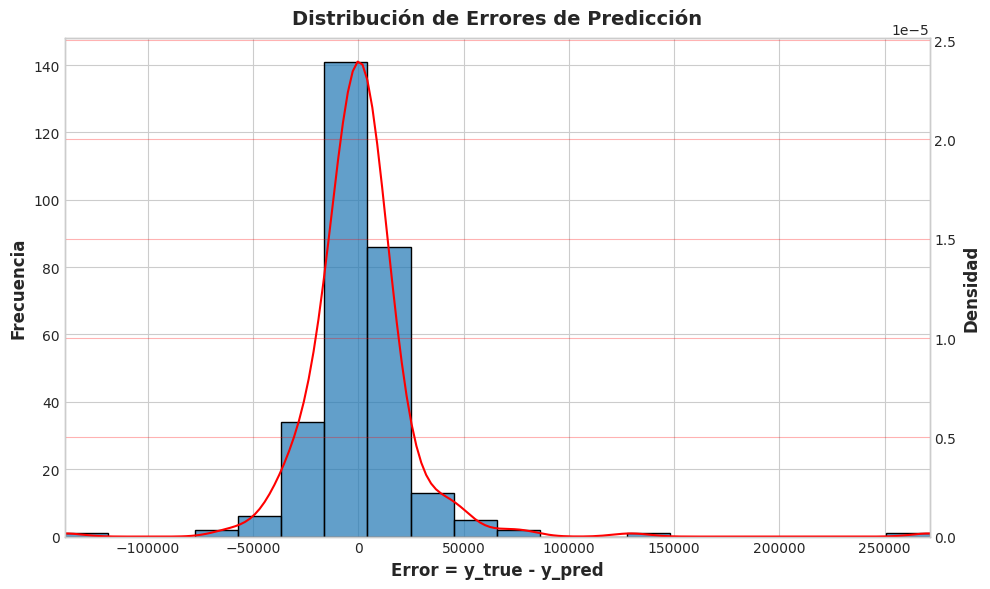

In [20]:
def plot_error_distribution(y_true, y_pred):
    """
    Esta función toma los valores verdaderos y las predicciones, calcula el error,
    y muestra un gráfico con un histograma de errores y una curva KDE de la densidad.
    
    :param y_true: Array de valores verdaderos.
    :param y_pred: Array de valores predichos.
    """
    
    
    # Calcular errores
    errors = y_true - y_pred.flatten() # El método flatten() convierte un array multidimensional (por ejemplo, una matriz de 2D) en un array de una sola dimensión (un vector).

    #     # Crear la figura y el eje principal
    #     fig, ax1 = plt.subplots()
    
    # Crear la figura y el eje principal con un tamaño de figura mayor
    fig, ax1 = plt.subplots(figsize=(10, 6))  # Ajusta el tamaño aquí (ancho, alto)

    # Crear el histograma en el eje principal
    sns.histplot(errors, bins=20, edgecolor='k', alpha=0.7, ax=ax1)
    ax1.set_xlabel('Error = y_true - y_pred')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Distribución de Errores de Predicción')
    
     # Ajustar el rango del eje x
    ax1.set_xlim([errors.min(), errors.max()])  # Ajusta según el rango de errores
    
    # Crear un segundo eje que comparte el mismo eje x
    ax2 = ax1.twinx()

    # Crear el KDE en el segundo eje
    sns.kdeplot(errors, ax=ax2, color='r')
    ax2.set_ylabel('Densidad')

    # Modificar la grilla del eje y de la derecha
    ax2.grid(True, which='both', axis='y', color='r', alpha=0.3)

    # Mostrar el gráfico
    plt.show()

# Ejemplo de uso
# plot_error_distribution(y_test, y_pred)

# plot error distribution
my_model = final_pipeline
y_pred = my_model.predict(X_test)
# y_pred = np.round(y_pred).astype(int)
mae = mean_absolute_error(y_test, y_pred)
# print(f'MAE en conjunto de prueba y calculado con prediccion: {mae}')
plot_error_distribution(y_test, y_pred)

# funciono

## (Sin ingnieria de caracteristicas)

# interpretacion ultimo modelo: 


### 1. **R² (Coeficiente de Determinación)**

- **Validation R²**: `0.9200`
- **Test R²**: `0.8977`

**Interpretación**:
- **Validation R²**: Un valor de `0.9200` indica que el modelo explica el `92%` de la variabilidad en los datos de validación. Esto sugiere que el modelo tiene un buen ajuste para los datos de validación.
- **Test R²**: Un valor de `0.8977` en el conjunto de prueba indica que el modelo explica el `90%` de la variabilidad en los datos de prueba. Aunque ligeramente inferior al de validación, sigue siendo una buena puntuación que sugiere que el modelo generaliza bien a datos nuevos.

### 2. **MAE (Error Absoluto Medio)**

- **Validation MAE**: `14,563.59`
- **Test MAE**: `15,020.20`

**Interpretación**:
- **Validation MAE**: Un MAE de `14,563.59` significa que, en promedio, el modelo se equivoca en `14,563.59` unidades en el conjunto de validación.
- **Test MAE**: Un MAE de `15,020.20` en el conjunto de prueba indica que el modelo tiene un error promedio de `15,020.20` unidades en datos no vistos. La diferencia entre el MAE de validación y el MAE de prueba es relativamente pequeña, lo que sugiere que el modelo ha generalizado bien, aunque el error es ligeramente mayor en el conjunto de prueba.

### 3. **RMSE (Raíz del Error Cuadrático Medio)**

- **Validation RMSE**: `21,034.90`
- **Test RMSE**: `27,007.30`

**Interpretación**:
- **Validation RMSE**: Un RMSE de `21,034.90` indica que la raíz cuadrada del promedio de los errores al cuadrado en la validación es `21,034.90` unidades. RMSE es sensible a los errores grandes, por lo que un valor más alto puede indicar que el modelo comete errores relativamente grandes en algunos casos.
- **Test RMSE**: Un RMSE de `27,007.30` en el conjunto de prueba es más alto que el de validación. Esto sugiere que, aunque el modelo se desempeña bien en general, puede haber ciertos errores significativos cuando se enfrenta a datos nuevos.

### **Resumen General**

- **Buena Generalización**: El modelo parece generalizar bien, dado que tanto el R² en validación como en prueba son altos, aunque hay una ligera caída en el R² del conjunto de prueba.
- **Error Absoluto y Cuadrático**: El MAE y el RMSE son relativamente altos, lo que indica que el modelo puede tener problemas con errores grandes en algunas predicciones. Esto es especialmente notable en el RMSE del conjunto de prueba, que es considerablemente mayor que en la validación.

### **Acciones Recomendadas**

1. **Revisar los Datos**: Asegúrate de que los datos de prueba y validación sean representativos del problema general.
2. **Explorar Ingeniería de Características**: La mejora de las características puede ayudar a reducir los errores.
3. **Ajustar el Modelo**: Considera probar otros modelos o ajustar los hiperparámetros para intentar reducir el RMSE.
4. **Análisis de Errores**: Investiga los casos con grandes errores para entender por qué el modelo puede estar fallando en esas instancias.

En resumen, tu modelo está bastante bien ajustado con buena capacidad de generalización, pero hay margen para mejorar la precisión y reducir el error, especialmente en datos nuevos.

probamos el tunning de hyperparametros de nuestro XGBoost, buscando la maximizacion del parametro r2
# Interpretacion. MODELO optimizado segun metrica R2

Vamos a desglosar cada una de estas métricas para entender qué indican sobre el rendimiento de tu modelo:

### **1. \( R^2 \) (Coeficiente de Determinación)**

- **Validation \( R^2 \) with best hyperparameters: 0.9048**
- **Test \( R^2 \) with best hyperparameters: 0.8991**

**Interpretación**:
- **Validation \( R^2 \)**: Un \( R^2 \) de 0.9048 en el conjunto de validación indica que el modelo explica aproximadamente el 90.48% de la variabilidad en la variable dependiente en el conjunto de validación. Esto sugiere un buen ajuste del modelo a los datos de validación.
- **Test \( R^2 \)**: Un \( R^2 \) de 0.8991 en el conjunto de prueba indica que el modelo explica aproximadamente el 89.91% de la variabilidad en el conjunto de prueba. Este valor es muy cercano al \( R^2 \) en la validación, lo que sugiere que el modelo se generaliza bien a nuevos datos.

### **2. MAE (Mean Absolute Error)**

- **Validation MAE with best hyperparameters: 16,231.79**
- **Test MAE with best hyperparameters: 15,418.81**

**Interpretación**:
- **Validation MAE**: El MAE en el conjunto de validación es 16,231.79. Esto significa que, en promedio, las predicciones del modelo están a 16,231.79 unidades del valor real en el conjunto de validación.
- **Test MAE**: El MAE en el conjunto de prueba es 15,418.81, que es ligeramente menor que el MAE en la validación. Esto indica que el modelo tiene un desempeño ligeramente mejor en el conjunto de prueba en comparación con el conjunto de validación.

**Nota**: El MAE es una medida de error absoluto promedio. Menor MAE indica mejores predicciones.

### **3. RMSE (Root Mean Squared Error)**

- **Validation RMSE with best hyperparameters: 22,952.04**
- **Test RMSE with best hyperparameters: 26,831.84**

**Interpretación**:
- **Validation RMSE**: El RMSE en el conjunto de validación es 22,952.04. El RMSE penaliza los errores grandes más que el MAE, ya que toma la raíz cuadrada de la media de los errores cuadrados. Este valor indica la magnitud de los errores en la validación, donde errores grandes tienen un mayor impacto.
- **Test RMSE**: El RMSE en el conjunto de prueba es 26,831.84, que es más alto que el RMSE en la validación. Esto sugiere que el modelo tiene mayores errores en el conjunto de prueba en comparación con el conjunto de validación.

**Nota**: El RMSE proporciona una medida del error en las mismas unidades que la variable de respuesta y es sensible a errores grandes. Un menor RMSE indica que el modelo tiene menos errores grandes en sus predicciones.

### **Resumen**

- **\( R^2 \)**: Ambos valores de \( R^2 \) (en validación y prueba) son altos, indicando que el modelo explica una gran parte de la variabilidad en los datos.
- **MAE**: El MAE muestra el error promedio en las predicciones. El hecho de que el MAE en el conjunto de prueba sea menor que en el de validación es una buena señal.
- **RMSE**: El RMSE en el conjunto de prueba es más alto que en el de validación, lo que sugiere que el modelo puede estar teniendo problemas con errores grandes en el conjunto de prueba.

En general, estas métricas indican que el modelo tiene un buen desempeño, pero también sugiere que puede haber margen para mejoras, especialmente en la reducción de errores grandes en el conjunto de prueba. La combinación de \( R^2 \), MAE y RMSE proporciona una visión completa del rendimiento del modelo, incluyendo su capacidad para explicar la variabilidad, el error promedio y la penalización por errores grandes.



# optimizacion por  MAE - sin ingenieria de caracteristicas - model. 1
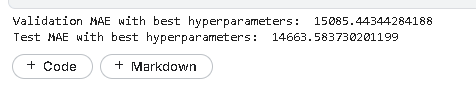

optimizacion por r2 - sin ingenieria de caracteristicas - model 2

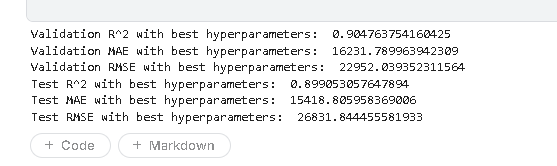

# Vemos el dataframe preprocesado


# Filtramos Caracteristicas, aplicamos MI o mutual information

Métrica de utilidad de características, una función que mide las asociaciones entre una característica y el objetivo.

La información mutua es una medida de la dependencia entre dos variables. En términos más técnicos, mide cuánto conocimiento se obtiene sobre una variable al conocer el valor de la otra. La información mutua se basa en la teoría de la información y se utiliza para evaluar la relación entre dos variables aleatorias.



La información mutua describe relaciones en términos de incertidumbre. La información mutua (MI) entre dos cantidades es una medida de hasta qué punto el conocimiento de una cantidad reduce la incertidumbre sobre la otra.